In [1]:
from setup import *
from load_data import *
from model import *
from render import *
from encoder import *
from ray import *

In [2]:
imgs, poses, [H, W, focal], K = load_data('/home/erl/yaw/cse291-nerf/data/bottles', 8)
poses[:,:,:,1:3] *= -1

800 800
(2, 100, 100, 100, 4)
(2, 100, 4, 4)


In [3]:
def pdf_sampling(z_vals, weights, N_f):  
    weights = weights + 1e-5  # prevent nans
    bins = torch.ones(weights.shape).to(device)
    bins *= z_vals

    pdf = weights / torch.sum(weights, dim=1, keepdim=True)
    cdf = torch.cumsum(pdf, -1)

    u = torch.rand(pdf.shape[0], N_f).to(device)
    inds = torch.searchsorted(cdf, u)

    # Invert CDF
    below = torch.maximum(torch.tensor([0]).to(device), inds-1)
    above = torch.minimum(torch.tensor([cdf.shape[-1]-1]).to(device), inds)

    cdf_g_below = cdf.gather(-1, below).to(device)
    cdf_g_above = cdf.gather(-1, above).to(device)

    bins_g_below = bins.gather(-1, below).to(device)
    bins_g_above = bins.gather(-1, above).to(device)

    denom = cdf_g_above - cdf_g_below
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u-cdf_g_below)/denom

    samples =bins_g_below + t * (bins_g_above-bins_g_below)

    return samples

In [4]:
def raw_to_rgb(raw, z_vals):
    H = raw.shape[0]
    sigma = F.relu(raw[...,0].reshape(H, -1))
    color = torch.sigmoid(raw[...,1:].reshape(H, -1, 3))
    dists = torch.concat([z_vals[..., 1:] - z_vals[..., :-1], torch.broadcast_to(torch.from_numpy(np.array([1e10])), z_vals[...,:1].shape).to(device)], -1)
    alpha = 1.-torch.exp(-sigma * dists)  
    weights = alpha * torch.cumprod(1.-alpha + 1e-10, -1)
    rgb_map = torch.sum(weights[...,None] * color, -2)
    acc_map = torch.sum(weights, -1)
    
    rgb_map = rgb_map + (1. - acc_map[..., None])
    #Weight = N*64
    return rgb_map, weights

In [5]:
def data_to_network_input(rays_o, rays_d, z_vals):
    # pts_flat [N*64*3]
    N = z_vals.shape[-1]
    norm_d = rays_d / torch.norm(rays_d, dim=1, keepdim=True)
    pts_flat = rays_o[...,None,:] + norm_d[...,None,:] * z_vals[...,:,None]
    view_direction = torch.ones([rays_d.shape[0], N, 3]).to(device)
    for i in range(N):
        view_direction[:, i, :] = norm_d
    #pts_flat shape, N*64*5)
    pts_flat = encoder_position(pts_flat, 10)
    view_direction = encoder_position(view_direction, 4)
    #pts_flat shape,  after encorder, N*64*(5*2*4 + 5))
    network_input = torch.cat((pts_flat, view_direction), 2)
    return network_input

In [6]:
def render_rays(fn, rays_o, rays_d, N_samples = 64 , near = 1, far = 5):

    z_vals = torch.linspace(near, far, N_samples_coasrs).to(device) 
    network_input = data_to_network_input(rays_o, rays_d, z_vals)
    raw = fn(network_input)
    coarse_rgb_map, coarse_weights = raw_to_rgb (raw, z_vals)

    return  coarse_rgb_map, coarse_weights

In [7]:
img2mse = lambda x, y : torch.mean((x - y) ** 2)
mse2psnr = lambda x : -10. * np.log(x) / np.log(10.)
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)
lrate = 5e-4
global_step = 0
lrate_decay = 250
batch_size = 32*32
near = 1
far = 5
N_samples_coasrs = 64
N_samples_fine = 128
fine_network = True

In [8]:
NeRF_coarse = NeRF(input_ch=63, input_ch_views=27, use_viewdirs=True).to(device)
NeRF_fine = NeRF(input_ch=63, input_ch_views=27, use_viewdirs=True).to(device)

grad_vars = list(NeRF_coarse.parameters()) + list(NeRF_fine.parameters())


optimizer = torch.optim.Adam(params=grad_vars, lr=lrate, betas=(0.9, 0.999))


N_iters = 1

#####  Prepare data  #####
all_rays_o = []
all_rays_d = []
all_images = []
for i in range(imgs[0].shape[0]):

    image = imgs[0][i][:,:,:3]
    c2w = poses[0][i]
    image = torch.Tensor(image)
    c2w = torch.Tensor(c2w)
    rays_o, rays_d = get_rays(H, W, focal, c2w)

    rays_o = rays_o
    rays_d = rays_d

    rays_o = rays_o.reshape([-1, 3])
    rays_d = rays_d.reshape([-1, 3])
    image = image.reshape([-1, 3])

    all_rays_o.append(rays_o)
    all_rays_d.append(rays_d)
    all_images.append(image)


all_rays_o = torch.concat(all_rays_o)
all_rays_d = torch.concat(all_rays_d)
all_images = torch.concat(all_images)
print(all_rays_o.shape)

train_data = torch.cat([all_rays_o, all_rays_d, all_images], axis = 1)
train_data = train_data[torch.randperm(train_data.size()[0])]
print(train_data.shape)

all_rays_o = train_data[:,:3]
all_rays_d = train_data[:,3:6]
all_images = train_data[:,6:]


loss_record = []
psny = []
    #####  Core optimization loop  #####
for epoch in range(N_iters):
    for i in range(0, all_images.shape[0], batch_size):
    
        input_rays_o = all_rays_o[i:i+batch_size].to(device)
        input_rays_d = all_rays_d[i:i+batch_size].to(device)
        input_images = all_images[i:i+batch_size].to(device)

        #predict_rgb, fine_predict_rgb = render_rays(NeRF_coarse.forward, NeRF_fine.forward, input_rays_o, input_rays_d)

# coarse step
        z_vals = torch.linspace(near, far, N_samples_coasrs).to(device) 
        network_input = data_to_network_input(input_rays_o, input_rays_d, z_vals)
        raw = NeRF_coarse.forward(network_input)
        coarse_rgb_map, coarse_weights = raw_to_rgb (raw, z_vals)

        optimizer.zero_grad()
        img_loss = img2mse(coarse_rgb_map, input_images)
        #img_loss.backward()
        #optimizer.step()

        if fine_network:
# resampling
            z_vals_fine =  pdf_sampling(z_vals, coarse_weights, N_samples_fine)    

# fine step        
            network_input_fine =  data_to_network_input(input_rays_o, input_rays_d, z_vals_fine)
            raw_fine = NeRF_fine.forward(network_input_fine.float())
            fine_rgb_map, fine_weights = raw_to_rgb (raw_fine, z_vals_fine)

            img_loss = img_loss + img2mse(fine_rgb_map, input_images)
        
        img_loss.backward()
        optimizer.step()


    ###   update learning rate   ###

        decay_rate = 0.1
        decay_steps = lrate_decay * 1000
        new_lrate = lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        global_step += 1

        loss_record.append(img_loss.item())
        psny.append(mse2psnr(img_loss.item()))
        
    #plt.plot(loss_record)
    #plt.show()


torch.Size([1000000, 3])
torch.Size([1000000, 9])


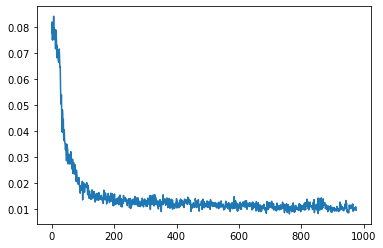

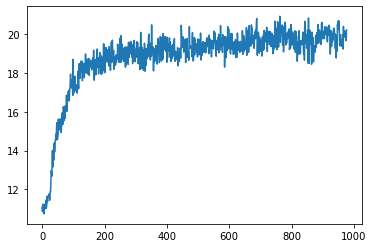

In [20]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.show()
plt.plot(psny)
plt.show()

In [21]:
torch.save(NeRF_coarse, 'model.pth')
np.save("loss", loss_record)

In [31]:
## test
    #out_imgs.append(image)
def test()
with torch.no_grad():
    NeRF_coarse = torch.load('model.pth').to(device)
    NeRF_coarse.eval()


    basedir= "data/bottles"
    pose_root = os.path.join(basedir, "pose")
    test_pose_file = ["1_val_0063", "2_test_0000","2_test_0016", "2_test_0055", "2_test_0093", "2_test_0160" ]
    poses = []
    for f in test_pose_file :   
        poses.append(np.loadtxt(os.path.join(pose_root, f+".txt")))

    out_imgs = []
    for pose in poses:
        pose[:,1:3] *= -1
        c2w = torch.Tensor(pose)
        rays_o, rays_d = get_rays(H, W, focal, c2w)
        rays_o = rays_o.reshape([-1, 3])
        rays_d = rays_d.reshape([-1, 3])

        output = []
        for i in tqdm(range(0, rays_o.shape[0], batch_size)):
    
            input_rays_o = rays_o[i:i+batch_size].to(device)
            input_rays_d = rays_d[i:i+batch_size].to(device)

            predict_rgb, _ = render_rays(NeRF_coarse.forward, input_rays_o, input_rays_d, 64, 1, 5)
            rgb = predict_rgb.to("cpu")
            output.append(rgb)
    
        image = torch.concat(output)
        image = image.reshape([H, W, 3])
        out_imgs.append(image)





100%|██████████| 10/10 [00:00<00:00, 48.85it/s]


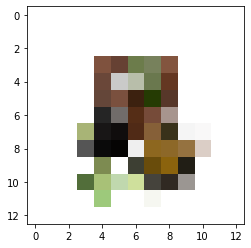

In [33]:
img = imgs[1, 0, :, :,0:3]
plt.imshow(img[::8,::8])
plt.show()

torch.Size([100, 100, 3])


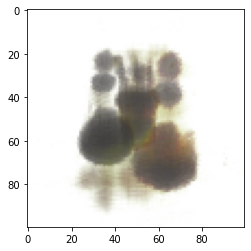

torch.Size([100, 100, 3])


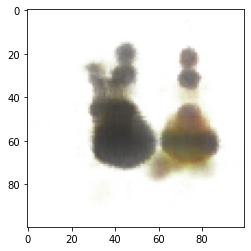

torch.Size([100, 100, 3])


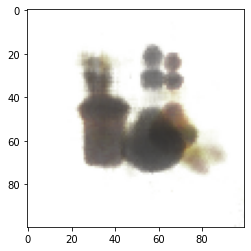

torch.Size([100, 100, 3])


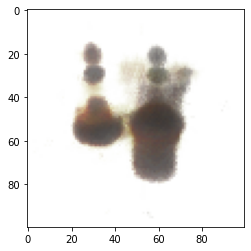

torch.Size([100, 100, 3])


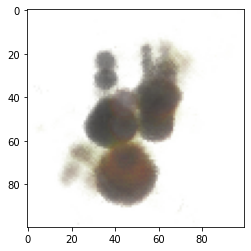

torch.Size([100, 100, 3])


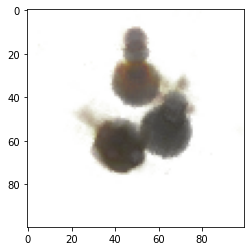

In [32]:
import matplotlib.pyplot as plt
for img in out_imgs:
    print(img.shape)
    plt.imshow(img)
    plt.show()